In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from IPython.display import display
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler      # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cub200/CUB_200_2011/image_class_labels.txt
/kaggle/input/cub200/CUB_200_2011/images.txt
/kaggle/input/cub200/CUB_200_2011/train_test_split.txt
/kaggle/input/cub200/CUB_200_2011/README
/kaggle/input/cub200/CUB_200_2011/classes.txt
/kaggle/input/cub200/CUB_200_2011/bounding_boxes.txt
/kaggle/input/cub200/CUB_200_2011/parts/part_click_locs.txt
/kaggle/input/cub200/CUB_200_2011/parts/parts.txt
/kaggle/input/cub200/CUB_200_2011/parts/part_locs.txt
/kaggle/input/cub200/CUB_200_2011/attributes/image_attribute_labels.txt
/kaggle/input/cub200/CUB_200_2011/attributes/class_attribute_labels_continuous.txt
/kaggle/input/cub200/CUB_200_2011/attributes/certainties.txt
/kaggle/input/cub200/CUB_200_2011/images/187.American_Three_toed_Woodpecker/American_Three_Toed_Woodpecker_0034_796165.jpg
/kaggle/input/cub200/CUB_200_2011/images/187.American_Three_toed_Woodpecker/American_Three_Toed_Woodpecker_0047_796185.jpg
/kaggle/input/cub200/CUB_200_2011/images/187.American_Three_toed_Woodpecker/A

In [2]:
from torchvision import transforms
input_dir = "/kaggle/input/cub200/CUB_200_2011/images"

transforms_data = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )])
dataset = torchvision.datasets.ImageFolder(input_dir, transform = transforms_data)

In [3]:
def get_subset(indices, start, end):
    return indices[start : start + end]


len_dataset = len(dataset)

TRAIN_PCT, VALIDATION_PCT = 0.6, 0.2  
train_count = int(len_dataset * TRAIN_PCT)
validation_count = int(len_dataset * VALIDATION_PCT)

indices = torch.randperm(len_dataset)

train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len_dataset)

In [4]:
dataloaders = {
    "train": DataLoader(dataset, batch_size = 32, sampler=SubsetRandomSampler(train_indices)),
    "validation": DataLoader(dataset, batch_size = 32, sampler=SubsetRandomSampler(validation_indices)),
    "test": DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))
}

In [5]:
train_data_loader = dataloaders["train"]
val_data_loader = dataloaders["validation"]
test_data_loader = dataloaders["test"]
print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

221
74
2359


In [6]:
class CNN_redux(nn.Module):
    def __init__(self, num_classes = 200):
        super(CNN_redux, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=5, padding = 1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    
                    nn.Conv2d(32, 64, kernel_size=5, padding=1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    
                    nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(128),
                    nn.MaxPool2d(kernel_size=2, stride=2),
        
                    nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(256),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                    )
        
        self.classifier = nn.Sequential(
                            nn.Linear(256 * 9 * 9, 1024),
                            nn.ReLU(),
                            nn.Dropout(0.2),
            
                            nn.Linear(1024, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
            
                            nn.Linear(512, 256),
                            nn.ReLU(),
    
                            nn.Linear(256, 200))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

In [7]:
if os.path.isfile("/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth") == False:
    model = torchvision.models.resnet34(pretrained=True) 
    for param in model.parameters():
        param.requires_grad = False

    n_inputs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(n_inputs, 200))

else:
    print("Already Downloaded")

model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total params = ", pytorch_total_params)
print("Total trainable params = ", pytorch_total_params_trainable)

Total params =  21387272
Total trainable params =  102600


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 30

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [10]:
# model = nn.DataParallel(model)
model = model.to(device=device)  
PATH = "/kaggle/working/best_model.pth"


if os.path.isfile(PATH) == False:
    for epoch in range(epochs):
        model.train()
        
        correct_training = 0
        correct_validation = 0  
        denom_train = 0
        denom_val = 0
        loss_list = []
        loss_val_list = []
        print("EPOCH: ", epoch + 1)
        for t, (x, y) in enumerate(train_data_loader):

            optimizer.zero_grad()

            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x) 

            pred = nn.LogSoftmax(dim = 1)
            predictions = pred(scores)
            predictions = torch.argmax(predictions, axis = 1)

            loss = nn.functional.cross_entropy(scores, y)      

            loss.backward()

            optimizer.step()

            correct_training += sum(y == predictions).item()
            denom_train += y.shape[0]
            loss_list.append(loss.item())

        print("Got {}/{} correct".format(correct_training, denom_train))
        print("Training Loss = {:.4f}, Epoch Training Accuracy = {:.4f}\n".format(sum(loss_list) / len(loss_list), 
                                                                       ((correct_training / denom_train) * 100)))

        for t_val, (x_val, y_val) in enumerate(val_data_loader): 

            x_val = x_val.to(device=device, dtype=dtype)  
            y_val = y_val.to(device=device, dtype=torch.long)  

            scores_val = model(x_val)        

            pred_val = nn.LogSoftmax(dim = 1)
            predictions_val = pred_val(scores_val)
            predictions_val = torch.argmax(predictions_val, axis = 1)
            
            loss_val = nn.functional.cross_entropy(scores_val, y_val) 
            loss_val_list.append(loss_val.item())
            
            correct_validation += sum(y_val == predictions_val).item()
            denom_val += y_val.shape[0]

        print("Got {}/{} correct".format(correct_validation, denom_val))
        print("Validation Loss = {:.4f}, Epoch Validation Accuracy = {:.4f}\n".format(sum(loss_val_list) / len(loss_val_list), (correct_validation / denom_val) * 100))   
    torch.save(model, PATH)
    print("Training Completed Now.")

else:
    print("Training Completed Already.")

EPOCH:  1
Got 129/7072 correct
Training Loss = 5.2529, Epoch Training Accuracy = 1.8241

Got 84/2357 correct
Validation Loss = 5.0382, Epoch Validation Accuracy = 3.5639

EPOCH:  2
Got 560/7072 correct
Training Loss = 4.7528, Epoch Training Accuracy = 7.9186

Got 204/2357 correct
Validation Loss = 4.6850, Epoch Validation Accuracy = 8.6551

EPOCH:  3
Got 1108/7072 correct
Training Loss = 4.3598, Epoch Training Accuracy = 15.6674

Got 277/2357 correct
Validation Loss = 4.3758, Epoch Validation Accuracy = 11.7522

EPOCH:  4
Got 1627/7072 correct
Training Loss = 4.0254, Epoch Training Accuracy = 23.0062

Got 385/2357 correct
Validation Loss = 4.1217, Epoch Validation Accuracy = 16.3343

EPOCH:  5
Got 2139/7072 correct
Training Loss = 3.7258, Epoch Training Accuracy = 30.2460

Got 481/2357 correct
Validation Loss = 3.9155, Epoch Validation Accuracy = 20.4073

EPOCH:  6
Got 2505/7072 correct
Training Loss = 3.4827, Epoch Training Accuracy = 35.4214

Got 545/2357 correct
Validation Loss = 3.

In [11]:
model = torch.load(PATH)

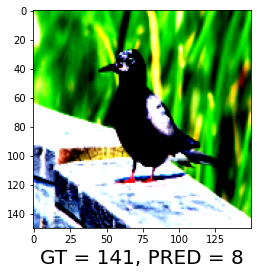

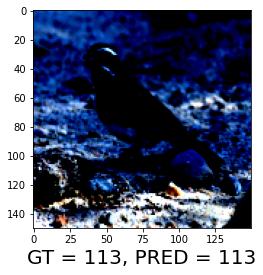

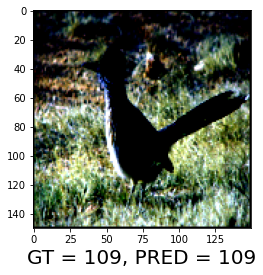

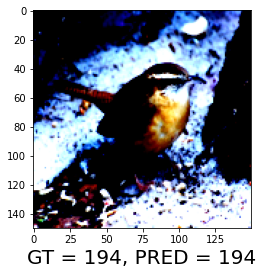

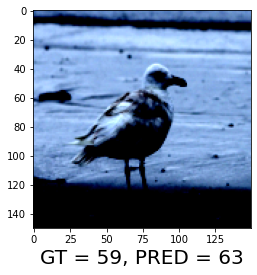

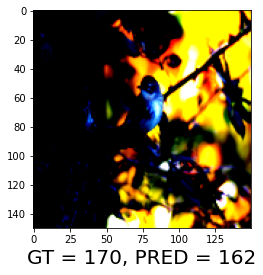

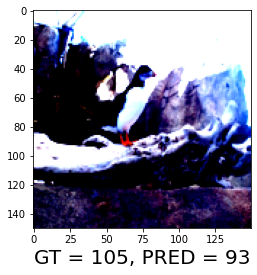

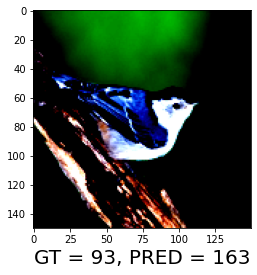

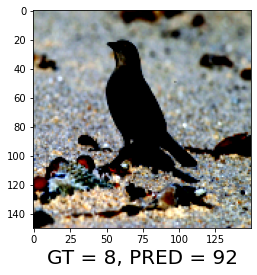

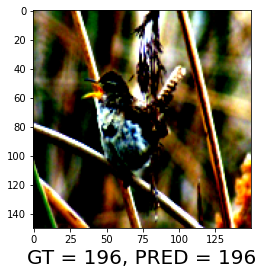

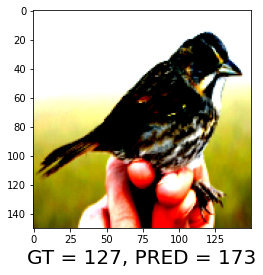

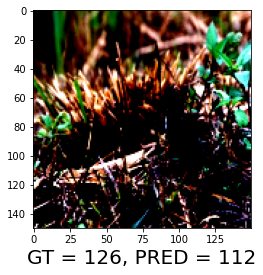

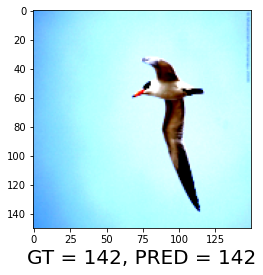

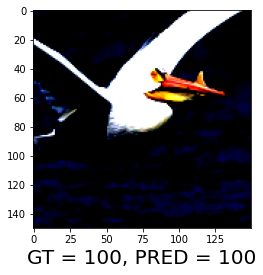

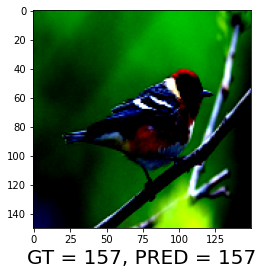

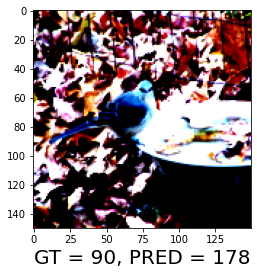

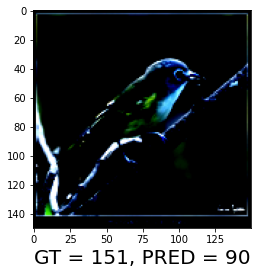

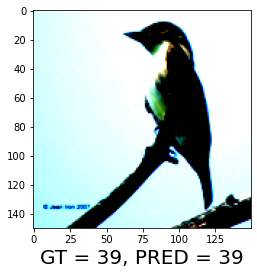

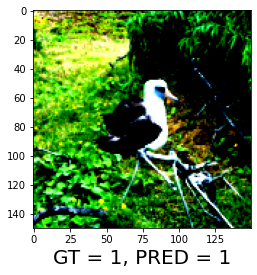

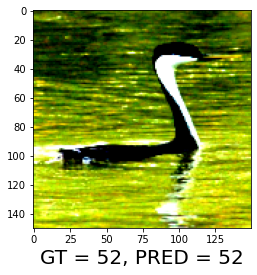

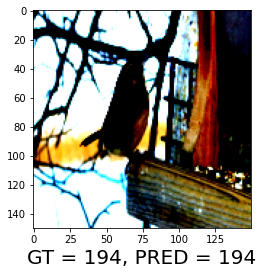

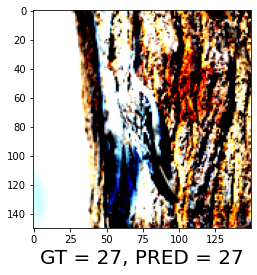

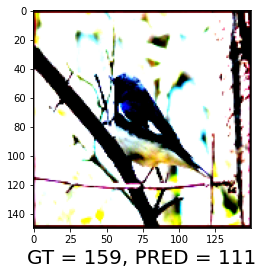

Got 950/2359 correct
Test Accuracy = 40.2713



In [12]:
import matplotlib.pyplot as plt
model.eval()
    
correct_test = 0
denom_test = 0

index_list = []
pred_list = []
gt_list = []

for t_test, (x_test, y_test) in enumerate(test_data_loader):
    
    gt_list.append(y_test.item())       
    
    x_test = x_test.to(device=device, dtype=dtype)  
    y_test = y_test.to(device=device, dtype=torch.long)

    scores_test = model(x_test) 

    pred_test = nn.LogSoftmax(dim = 1)
    predictions_test = pred(scores_test)
    predictions_test = torch.argmax(predictions_test, axis = 1)
    
    if (t_test + 1) % 100 == 0:
        plt.imshow(x_test.cpu().numpy().squeeze().transpose(1, 2, 0))
        plt.xlabel("GT = {}, PRED = {}".format(y_test.item(), predictions_test.item()), fontsize = 20)
        plt.show()
        
    
    correct_test += sum(y_test == predictions_test).item()
    denom_test += y_test.shape[0]
    
    pred_list.append(predictions_test.item())
    index_list.append(t_test + 1)
    
    
print("Got {}/{} correct".format(correct_test, denom_test))
print("Test Accuracy = {:.4f}\n".format((correct_test / denom_test) * 100)) 